In [1]:
# A note on regridding
    # We use the XESMF package to regrid data to a 1x1 degree global grid
    # From their documentation, "When dealing with global grids, we need to set periodic=True, otherwise data along the meridian line will be missing"
    # "For real-world data, it is generally recommended to use conservative for [high resolution to low resolution],
        # because it takes average over small source grid boxes, while bilinear and nearest_s2d effectively throw away most of source grid boxes." 
        # More at https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html
    # We follow this except for ERA5 SLP which we use bilinear. Using conservative and conservative_normed gives a warning "Latitude is outside of [-90, 90]" and we have a separate coastal filling process. 
        # See https://xesmf.readthedocs.io/en/latest/notebooks/Masking.html

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import datetime
import numpy.ma as ma
import glob
import matplotlib.pyplot as plt
import re
import os
import yaml

In [3]:
#This file contains configuration details like API keys and passwords
global_vars = yaml.safe_load(open('../config.yml', 'r') )

In [4]:
#if running locally; some issues with xesmf versioning so need this:
ESMFMKFILE = global_vars['ESMFMKFILE']
%env ESMFMKFILE $ESMFMKFILE
import xesmf

env: ESMFMKFILE=C:/UserPrograms/anaconda3/envs/leap_co2_v1/Library/lib/esmf.mk


In [5]:
#This has custom functions - several but the fCO2_to_pCO2 function is key
%run ./00_custom_functions.ipynb
#fCO2_to_pCO2(380, 8) #381.5

In [6]:
# To ingest the raw data downloaded in the previous script, we need to point to the location of the downloads
# Data will be read at this location in folders such as root/SST/originals/ and root/SSS/orginals/
# Processed data will be saved to folders such as root/SST/processed/ 
# Note that data file names within these folders have been hardcoded in each section below
cloud = True
if cloud:
    data_folder_root = global_vars['download_folder_cloud']
else:
    data_folder_root = global_vars['download_folder_local']
print(data_folder_root)


# The following two variables are used to slice the data to desired time frames for consistency or to backfill historical data will averages.
# Given the time range limitiations of the raw data, this primarily affects MLD (1 year repeated) and CHL (linear interpoloation)
processed_start_yearmonth = '1982-01'  
processed_end_yearmonth = '2023-04'   
figsizew, figsizeh = 6, 3  #figure size for maps (width/height)

/data/artemis/workspace/ds4114/online_data/


In [7]:
#create desired resolution and time frame
ylat = xr.DataArray(data=[x+.5 for x in range(-90, 90, 1)], dims=['ylat'], coords=dict( ylat=(['ylat'],[x+.5 for x in range(-90, 90, 1)]) ),)
xlon = xr.DataArray(data=[x+.5 for x in range(-180,180,1)], dims=['xlon'], coords=dict( xlon=(['xlon'],[x+.5 for x in range(-180,180,1)]) ),)
ttime = pd.date_range(start=str(processed_start_yearmonth), end=str(processed_end_yearmonth),freq='MS') + np.timedelta64(14, 'D') #time should be monthly on the middle of the month
        #note that the time doesnt affect regridding but we do use this time to overwrite the monthly dates so its consistent

ideal_grid = xr.Dataset({'time':(['time'],ttime.values), 'latitude':(['latitude'],ylat.values),'longitude':(['longitude'],xlon.values)}) #must be named this way for old XESFM versions

## Temperature (SST)

In [8]:
sst = xr.open_dataset(data_folder_root+r'SST/originals/SST_NOAA_OI-V2-HighRes_198109-202306.nc')  
#sst

In [9]:
%%time
sst_filtered = sst.sel(time=slice(str(processed_start_yearmonth),str(processed_end_yearmonth))) #already monthly so select desired years
sst_regridder = xesmf.Regridder(sst_filtered, ideal_grid, 'conservative', periodic=True)  #see notes above on why conservative over bilinear
sst_out = sst_regridder(sst_filtered, keep_attrs=True)
#sst_out

CPU times: user 30.6 s, sys: 4.17 s, total: 34.8 s
Wall time: 34.8 s


In [10]:
sst_out = sst_out.rename({'latitude': 'ylat','longitude': 'xlon'}) #rename to be consistent with prior work
sst_out = sst_out.assign_coords(time=ttime) #overwrite time dimension to be midmonth

In [11]:
output_netcdf_with_date(sst_out, data_folder_root+'SST/processed/', 'SST_NOAA_OI-V2-1x1')

Cancelling output - SST_NOAA_OI-V2-1x1_198201-202304.nc already exists in /data/artemis/workspace/ds4114/online_data/SST/processed/


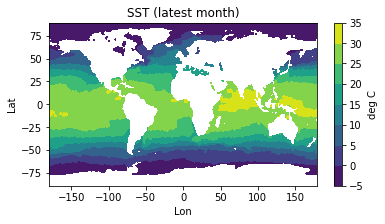

In [12]:
fig = plt.figure(figsize=(figsizew,figsizeh))
plt.contourf(ideal_grid.longitude,ideal_grid.latitude,sst_out.sst[-1,:,:]) #just choosing latest time slice
plt.title('SST (latest month)'); plt.xlabel('Lon'); plt.ylabel('Lat')
plt.colorbar().set_label('deg C');

## Salinity (SSS)

In [13]:
sss = xr.open_mfdataset(data_folder_root+'SSS/originals/EN.4.2.2.f.analysis.g10.*.nc') 
#sss

In [14]:
%%time
#effectively ignore the depth dimension because we dont need it
sss_nodepth = xr.Dataset({'sss':(['time','lat','lon'],sss.salinity[:,0,:,:].values),'time':(['time'],sss.time.data),'lat':(['lat'],sss.lat.data),'lon':(['lon'],sss.lon.data)})
#Note this removes attributes from SSS raw data so we lose some metadata but this is OK for this analysis
sss_filtered = sss_nodepth.sel(time=slice(str(processed_start_yearmonth),str(processed_end_yearmonth))) #filter years

#Regrid lat/lon
sss_regridder = xesmf.Regridder(sss_filtered, ideal_grid, 'bilinear', periodic=True)  #data is already 1x1 but we want to shift coordinates
sss_out = sss_regridder(sss_filtered, keep_attrs=True)
#sss_out

CPU times: user 47.7 s, sys: 4.23 s, total: 52 s
Wall time: 1min 11s


In [15]:
sss_out = sss_out.rename({'latitude': 'ylat','longitude': 'xlon'}) #rename to be consistent with prior work
sss_out = sss_out.assign_coords(time=ttime) #overwrite time dimension to be midmonth
#sss_out = sss_out.assign_coords(time=ttime[:-1]) #you can use this line if SSS hasnt updated and we are missing the last month.

In [16]:
output_netcdf_with_date(sss_out, data_folder_root+'SSS/processed/', 'SSS_Met-Office-Hadley-Centre_EN422f-g10-analyses')

Cancelling output - SSS_Met-Office-Hadley-Centre_EN422f-g10-analyses_198201-202304.nc already exists in /data/artemis/workspace/ds4114/online_data/SSS/processed/


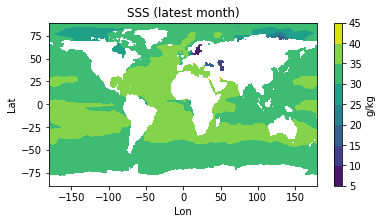

In [17]:
fig = plt.figure(figsize=(figsizew,figsizeh))
plt.contourf(ideal_grid.longitude,ideal_grid.latitude,sss_out.sss[-1,:,:]) #just choosing latest time slice
plt.title('SSS (latest month)'); plt.xlabel('Lon'); plt.ylabel('Lat')
plt.colorbar().set_label('g/kg');

## Mixed Layer Depth (MLD)

In [18]:
mld_ds = xr.open_dataset(data_folder_root+r'MLD/originals/MLD_IFREMER-deBoyer_DT02-c1m_2008.nc', decode_times=False)
mld = mld_ds.mld  #just need the mld variable. Data is 2x2 resolution

In [19]:
#there are strange anomalies in the raw data which we are going to filter out
mld_filtered = mld.where(((mld>0)&(mld<5000))) 

#TODO - Document these steps
mld_filtered2 = np.where(np.isnan(mld_filtered), ma.array(mld_filtered, mask=np.isnan(mld_filtered)).mean(axis=2)[:,:,np.newaxis], mld_filtered)
mld_filtered2 = np.where(mld_filtered2==0,np.nan,mld_filtered2)
mld_filtered2 = mld_filtered2 #[0:12,:,:] only 1 year needed

In [20]:
mld_in = xr.Dataset({'mld':(['time','lat','lon'],mld_filtered2),'time':(['time'],range(0,12)),'lat':(['lat'],mld_filtered.lat.values),'lon':(['lon'],mld_filtered.lon.values)})

mld_regridder = xesmf.Regridder(mld_in, ideal_grid, 'bilinear', periodic=True) 
mld_out = mld_regridder(mld_filtered2, keep_attrs=True)
mld_out = np.where(np.isnan(mld_out),0,mld_out)
#mld_out

In [21]:
#we now have 12 months of MLD data, let's replicate for the desired time frame so merging is easier later
mld_out
mld_out_full = np.empty(shape=(len(ttime),180,360)) 
#now fill array with averaged year
for i, m in enumerate(ttime): 
    mld_out_full[i,:,:] = mld_out[m.month-1,:,:]
#mld_out_full

In [22]:
mld_out_full_xr = xr.Dataset({'mld':(["time","ylat","xlon"],mld_out_full.data)},
                        coords={'time': (['time'],ttime.values),'ylat':(['ylat'],ideal_grid.latitude.data),'xlon':(['xlon'],ideal_grid.longitude.data)})

In [23]:
output_netcdf_with_date(mld_out_full_xr, data_folder_root+'MLD/processed/', 'MLD_IFREMER-deBoyer_DT02-c1m-1x1')

Cancelling output - MLD_IFREMER-deBoyer_DT02-c1m-1x1_198201-202304.nc already exists in /data/artemis/workspace/ds4114/online_data/MLD/processed/


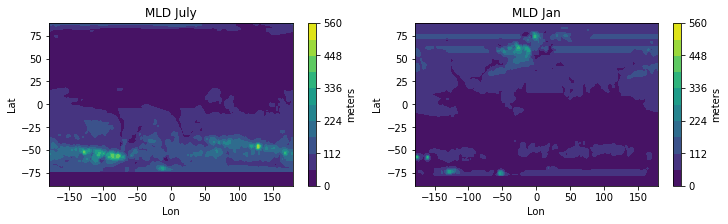

In [24]:
levelspace = np.linspace(0,560,11)
fig,ax = plt.subplots(1,2,figsize=(figsizew*2, figsizeh))
x0=ax[0].contourf(ideal_grid.longitude,ideal_grid.latitude,mld_out_full_xr.mld[6,:,:], levels=levelspace) #just choosing a summer month (July)
x1=ax[1].contourf(ideal_grid.longitude,ideal_grid.latitude,mld_out_full_xr.mld[0,:,:], levels=levelspace) #just choosing a winter month (Jan)
ax[0].set_title("MLD July"); ax[1].set_title("MLD Jan");
ax[0].set_xlabel('Lon'); ax[0].set_ylabel('Lat');
ax[1].set_xlabel('Lon'); ax[1].set_ylabel('Lat');
plt.colorbar(x0, ax=ax[0]).set_label('meters');
plt.colorbar(x1, ax=ax[1]).set_label('meters');

## Chlorophyll (CHL)

In [25]:
#0) First combine data and filter for the relevant time period. Because CHL data does not have a time dimension in raw data, we need to add it to each file before/during concatenation 
files = glob.glob(data_folder_root+'CHL/originals/*.nc')
chl = xr.concat([add_time_to_globcolour(fl) for fl in files], dim='time')
#chl
chl_filter = chl.sel(time=slice(str(processed_start_yearmonth),str(processed_end_yearmonth))) 

In [26]:
#1) Next we group by month to get and 'average' year
    #Note that we are using data from the desired time frame to calculate an average year. This means past data will change when more years are added.
chl_avg_by_month = chl_filter.CHL1_mean.groupby("time.month").mean("time")  #only need the mean variable
#2) Then we loop that year (duplicate) into two years so that we can linearly interpolate without boundary issues in Jan/Dec. We will only need the middle 12 months.
chl_looped = np.empty(shape=(24,180,360))  #2 years of data.
chl_looped[0:6,:,:] = chl_avg_by_month[6:12,:,:]  #set start of loop to be July to Dec. Winter at the north pole is at the end/start of the year
chl_looped[6:18,:,:] = chl_avg_by_month
chl_looped[18:24,:,:] = chl_avg_by_month[0:6,:,:]  #set end of loop to be Jan to Jun
chl_looped_xr = xr.Dataset({'chl':(['time','lat','lon'],chl_looped)},
                       coords={'time':(['time'],range(0,24)),'lat':(['lat'],chl_avg_by_month.lat.values),'lon':(['lon'],chl_avg_by_month.lon.values)})
chl_looped_interpolated = chl_looped_xr.chl.interpolate_na(dim='time',method='linear',limit=7)
chl_avg_year = chl_looped_interpolated[6:18,:,:]   #the full year we interpolated is in the middle. Starts in Jan.

In [27]:
#3) Now we fill in 1982 to 1997 with that averaged year
earliest_chl_date = chl.time.min().data.astype('datetime64[s]').item()
chl_missing_years = np.empty(shape=(sum(ttime < earliest_chl_date),180,360))  #create empty array of size equal to number of missing months
chl_missing_years = xr.DataArray(chl_missing_years, coords=dict(time=ttime[ttime < earliest_chl_date], lat=chl_avg_year.lat, lon=chl_avg_year.lon), dims=["time", "lat", "lon"]) #make it an xr
chl_avg_fullset = np.empty(shape=(len(ttime),180,360))   #this is just the average which we will use later to fill missing holes from interpolation
#now fill array with averaged year
for i, m in enumerate(ttime):   #loop through months between start and end date
    chl_avg_fullset[i,:,:] = chl_avg_year[m.month-1,:,:]
    if m < earliest_chl_date: 
        chl_missing_years[i,:,:] = chl_avg_year[m.month-1,:,:]
#chl_missing_years.shape

In [28]:
#4) Next, combine the pre-1997 set with the 1998+ data to get a full set. Then interpolate on full set again to fill missing points.
chl_filter_with_missing = xr.concat([chl_missing_years, chl_filter.CHL1_mean], dim='time')
chl_filter_interpolate = chl_filter_with_missing.interpolate_na(dim='time',method='linear',limit=7)

In [29]:
#5) For any remaining missing values that could not be interpolated, we fill with the averaged climatology
chl_filter_interpolate_xr = xr.Dataset({'chl':(['time','lat','lon'],chl_filter_interpolate.data)  #make as a dataset so we can use fillna
                                       #,'clim_repeat':(['time','lat','lon'], chl_avg_fullset)    #This field was used in a prior version of code but is not required
                            }, coords={'time':(['time'],chl_filter_interpolate.time.values),'lat':(['lat'],chl_filter_interpolate.lat.values),'lon':(['lon'],chl_filter_interpolate.lon.values)})
chl_filter_final = chl_filter_interpolate_xr.fillna(chl_avg_fullset) 

In [30]:
#6) Regrid 
chl_regridder = xesmf.Regridder(chl_filter_final, ideal_grid, 'bilinear', periodic=True)
chl_out = chl_regridder(chl_filter_final, keep_attrs=True)
chl_out = chl_out.rename({'latitude': 'ylat','longitude': 'xlon'}) 
chl_out['chl'].attrs['description'] = "Interpolated linearly between months, climatology prior to 1998-01"  
chl_out['chl'].attrs['units'] = "mg / m3"
#chl_out

In [31]:
output_netcdf_with_date(chl_out, data_folder_root+'CHL/processed/', 'CHL_ARI-ST-GlobColour_L3m-GLOB-100-merged-GSM-CHL1', False)

Cancelling output - CHL_ARI-ST-GlobColour_L3m-GLOB-100-merged-GSM-CHL1_198201-202304.nc already exists in /data/artemis/workspace/ds4114/online_data/CHL/processed/


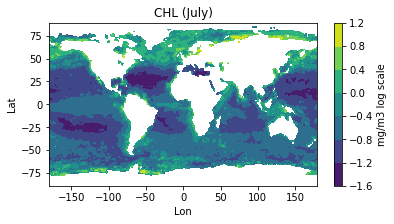

In [32]:
fig = plt.figure(figsize=(figsizew,figsizeh))
plt.contourf(ideal_grid.longitude,ideal_grid.latitude,np.ma.log10(chl_out.chl[12*20+6,:,:]))  #just one summer month; log scale to make more readable
plt.title('CHL (July)'); plt.xlabel('Lon'); plt.ylabel('Lat')
plt.colorbar().set_label('mg/m3 log scale');

## Sea Level Pressure (SLP)

In [33]:
era5 = xr.open_mfdataset(data_folder_root+r'SLP/originals/SLP_ECMWF_ERA5-monthly-reanalysis-MSLP_*.nc') 

In [34]:
%%time
#Regrid era5
mslp_highres = era5.sel(expver=1).msl/100  #do do not need the experimental/recent data because socat is only up till end of the prior yer. Also Pa to HPa. 
    #Note the expver variable in era5 indicates new experimental data: #https://confluence.ecmwf.int/pages/viewpage.action?pageId=173385064
mslp_highres = xr.Dataset({'mslp':(['time','latitude','longitude'],mslp_highres.data),'time':(['time'],mslp_highres.time.data),'latitude':(['latitude'],mslp_highres.latitude.data),'longitude':(['longitude'],mslp_highres.longitude.data)})
mslp_highres_regridder = xesmf.Regridder(mslp_highres, ideal_grid, 'bilinear', periodic=True) #See note above about bilinear vs conservative
mslp_out = mslp_highres_regridder(mslp_highres, keep_attrs=False)
#mslp_out

CPU times: user 14.3 s, sys: 389 ms, total: 14.7 s
Wall time: 14.7 s


In [35]:
mslp_out.mslp.attrs['units'] = 'hPa'

In [36]:
output_netcdf_with_date(mslp_out, data_folder_root+'SLP/processed/', 'SLP_ECMWF_ERA5-monthly-reanalysis-1x1-MSLP')

Cancelling output - SLP_ECMWF_ERA5-monthly-reanalysis-1x1-MSLP_197901-202305.nc already exists in /data/artemis/workspace/ds4114/online_data/SLP/processed/


## pCO2

In [37]:
socat = xr.open_dataset(data_folder_root+r'pCO2/originals/fCO2_SOCOVV_SOCAT-gridded-monthly_2022.nc') 

In [38]:
#get relevant variables and filter for desired years 
co2_processed_end_yearmonth = socat.tmnth.max().data.astype('datetime64[s]').item().strftime('%Y-%m') #Note that fCO2 is only up til 2 years ago if (released every June)
fco2 = socat.fco2_ave_weighted
fco2 = fco2.sel(tmnth=slice(str(processed_start_yearmonth),str(co2_processed_end_yearmonth))) 
fco2_sst = socat.sst_ave_weighted
fco2_sst = fco2_sst.sel(tmnth=slice(str(processed_start_yearmonth),str(co2_processed_end_yearmonth)))
fco2_mslp = mslp_out.mslp
fco2_mslp = fco2_mslp.sel(time=slice(str(processed_start_yearmonth),str(co2_processed_end_yearmonth)))

In [39]:
pco2 = fCO2_to_pCO2(fco2, fco2_sst, fco2_mslp, tempEQ_C=None)
pco2 = np.where((pco2>200)&(pco2<650),pco2,np.nan) #where socat pco2 values are <200 and >650 we are changing to nans as a source of quality control

In [40]:
#Realign time to our grid for each available month (ex shift from 16th to 15th for consistency)
fco2_ttime = ttime[pd.DataFrame(ttime,columns=['t']).t.between(fco2.tmnth.min().data.astype('datetime64[s]').item().strftime('%Y-%m'), fco2.tmnth.max().data.astype('datetime64[s]').item(), inclusive='both')]
    #Alternatively can use this: fco2_ttime = pd.date_range(start=fco2.tmnth.min().item(), end=fco2.tmnth.max().item(),freq='MS') + np.timedelta64(14, 'D')
#fco2_ttime

In [41]:
pco2_out = xr.Dataset(  {
                        'pco2':(["time","ylat","xlon"],pco2.data),
                        #'socat_mask':(["time","ylat","xlon"],np.where(~np.isnan(pco2),1,np.nan)),  #Prior code included additional variables which are not needed
                        #'socat_sst':(["time","ylat","xlon"],fco2_sst.data),
                        #'mslp':(["time","ylat","xlon"],fco2_mslp.data),
                        'fco2':(["time","ylat","xlon"],fco2.data)
                        },
                        coords={'time': (['time'],fco2_ttime.values),
                          'ylat': (['ylat'],fco2.ylat.data),
                          'xlon': (['xlon'],fco2.xlon.data)}
                    )
pco2_out.pco2.attrs['units'] = 'uatm'
pco2_out.pco2.attrs['description'] = 'uses fco2 (weighted), sst (weighted) and MSLP to convert to pCO2 via fCO2_to_pCO2 script'
pco2_out.pco2.attrs['description2'] = 'socat pco2 values <200 and >650 have been changed to nans as a source of quality control' 
#pco2_out.socat_sst.attrs['units'] = 'deg C'
#pco2_out.mslp.attrs['units'] = 'hPa'
pco2_out.fco2.attrs['units'] = 'uatm'
#pco2_out

In [42]:
output_netcdf_with_date(pco2_out, data_folder_root+'pCO2/processed/', 'pCO2_LEAP_SOCAT-ERA5-weighted', False)

Cancelling output - pCO2_LEAP_SOCAT-ERA5-weighted_198201-202212.nc already exists in /data/artemis/workspace/ds4114/online_data/pCO2/processed/


<ipython-input-43-972c11a5379c>:2: RuntimeWarning: All-NaN axis encountered
  plt.contourf(ideal_grid.longitude,ideal_grid.latitude,np.nanmax(pco2_out.pco2, axis=0))


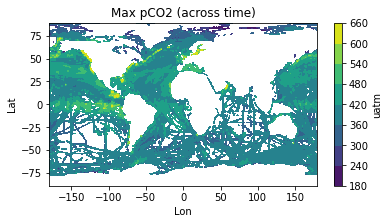

In [43]:
fig = plt.figure(figsize=(figsizew,figsizeh))
plt.contourf(ideal_grid.longitude,ideal_grid.latitude,np.nanmax(pco2_out.pco2, axis=0)) 
plt.title('Max pCO2 (across time)'); plt.xlabel('Lon'); plt.ylabel('Lat')
plt.colorbar().set_label('uatm');

# Atmospheric CO2 (xCO2)

In [44]:
#data was downloaded monthly as csv. Convert to a xarray
#Note that the number of header rows (55) is hardcoded here
xco2_df = pd.read_csv(data_folder_root+r'xCO2/originals/xCO2_NOAA_xCO2-mm-gl-monthly_197901-202306.csv', skiprows=55)  
#xco2_df.head(3)

In [46]:
#make time the index; drop unneeded columns; convert to xarray
xco2_df['time'] = xco2_df.apply(lambda row: datetime.datetime(int(row.year), int(row.month), 15), axis=1) #putting as 15th of the month
xco2_df['time'] = pd.to_datetime(xco2_df.time)
xco2_df.index = pd.DatetimeIndex(xco2_df.time)

xco2_xr = xco2_df[['trend']].to_xarray() #we only want the "trend" field because it matches historical work that did not factor seasonality 
xco2_xr_filtered = xco2_xr.sel(time=slice(str(processed_start_yearmonth),str(processed_end_yearmonth))) #filter for desired time
xco2_xr_filtered = xco2_xr_filtered.rename({'trend': 'xco2_trend'})
#xco2_xr_filtered

In [47]:
output_netcdf_with_date(xco2_xr_filtered, data_folder_root+'xCO2/processed/', 'xCO2_NOAA_xCO2-mm-gl-monthly')

Cancelling output - xCO2_NOAA_xCO2-mm-gl-monthly_198201-202303.nc already exists in /data/artemis/workspace/ds4114/online_data/xCO2/processed/


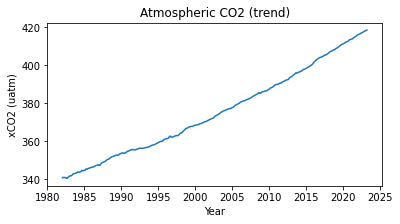

In [48]:
fig = plt.figure(figsize=(figsizew,figsizeh))
plt.plot(xco2_xr_filtered.time,xco2_xr_filtered.xco2_trend)
plt.title('Atmospheric CO2 (trend)'); plt.xlabel('Year'); plt.ylabel('xCO2 (uatm)');